In [58]:
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from darts import TimeSeries
from darts.utils.statistics import check_seasonality

tqdm.pandas()

### What relationships exist between weather attributes and energy consumption?

In [31]:
data_path = Path("../data")
energy_weather_data_path = data_path/"output"/"energy_weather_data.parquet"
energy_weather_df = pd.read_parquet(energy_weather_data_path)

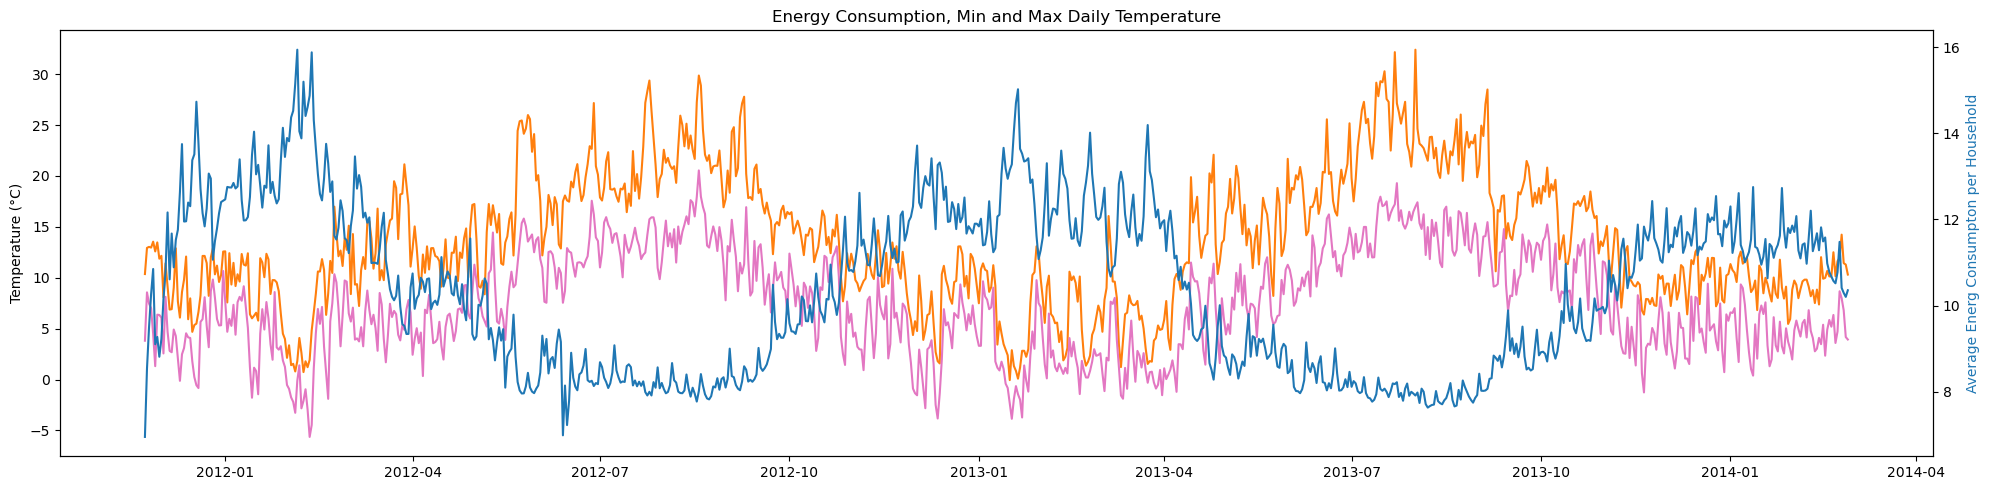

In [32]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(energy_weather_df.index, energy_weather_df['temperatureMax'], color='tab:orange')
ax1.plot(energy_weather_df.index, energy_weather_df['temperatureMin'], color='tab:pink')
ax1.set_ylabel('Temperature (°C)')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energ Consumpton per Household', color='tab:blue')
plt.title('Energy Consumption, Min and Max Daily Temperature')
fig.tight_layout()
plt.show()

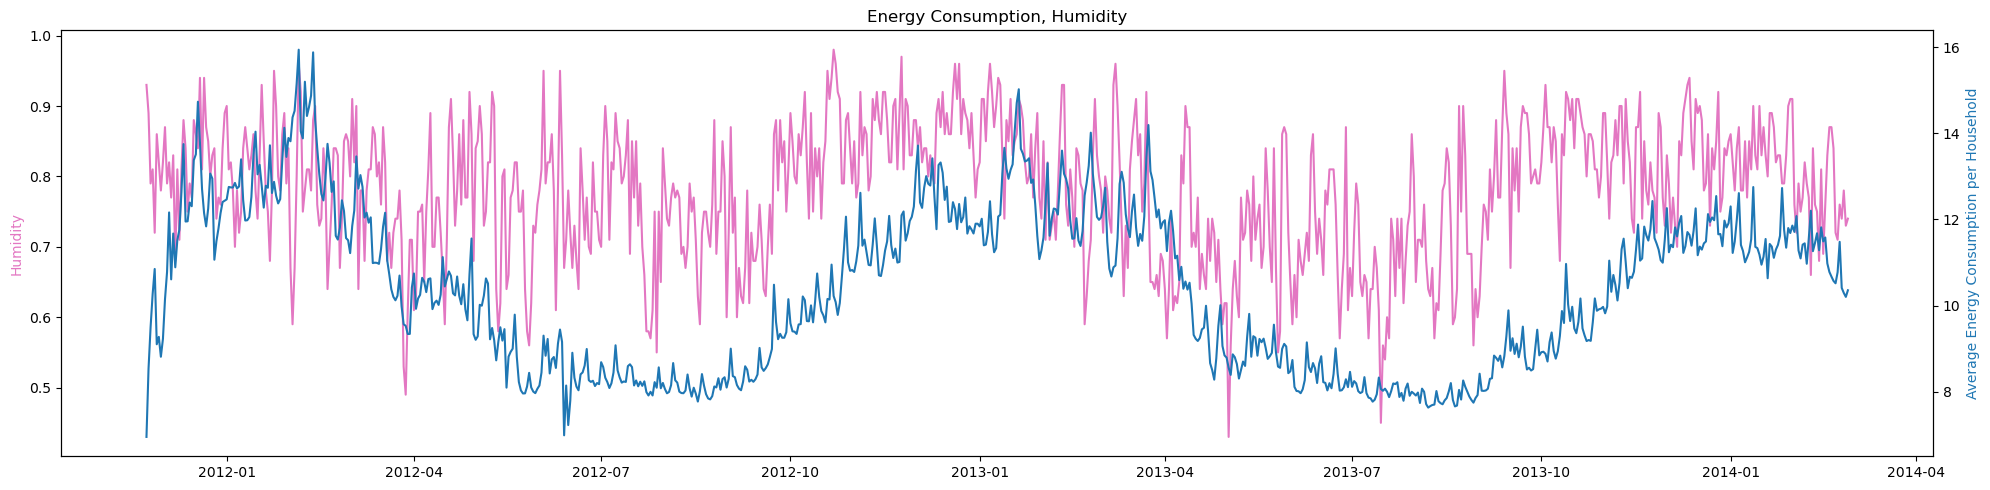

In [33]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(energy_weather_df.index, energy_weather_df['humidity'], color='tab:pink')
ax1.set_ylabel('Humidity',color = 'tab:pink')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energy Consumption per Household', color='tab:blue')
plt.title('Energy Consumption, Humidity')
fig.tight_layout()
plt.show()

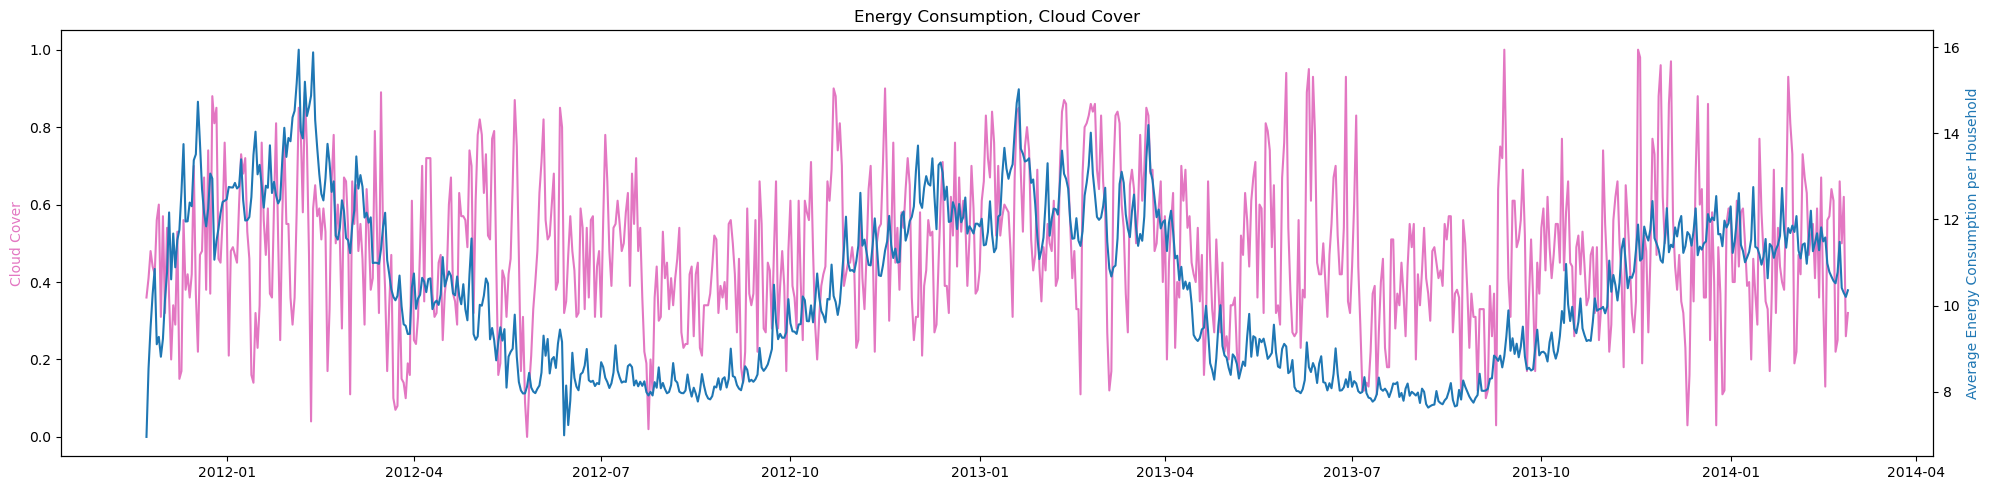

In [34]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(energy_weather_df.index, energy_weather_df['cloudCover'], color='tab:pink')
ax1.set_ylabel('Cloud Cover', color='tab:pink')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energy Consumption per Household', color='tab:blue')
plt.title('Energy Consumption, Cloud Cover')
fig.tight_layout()
plt.show()

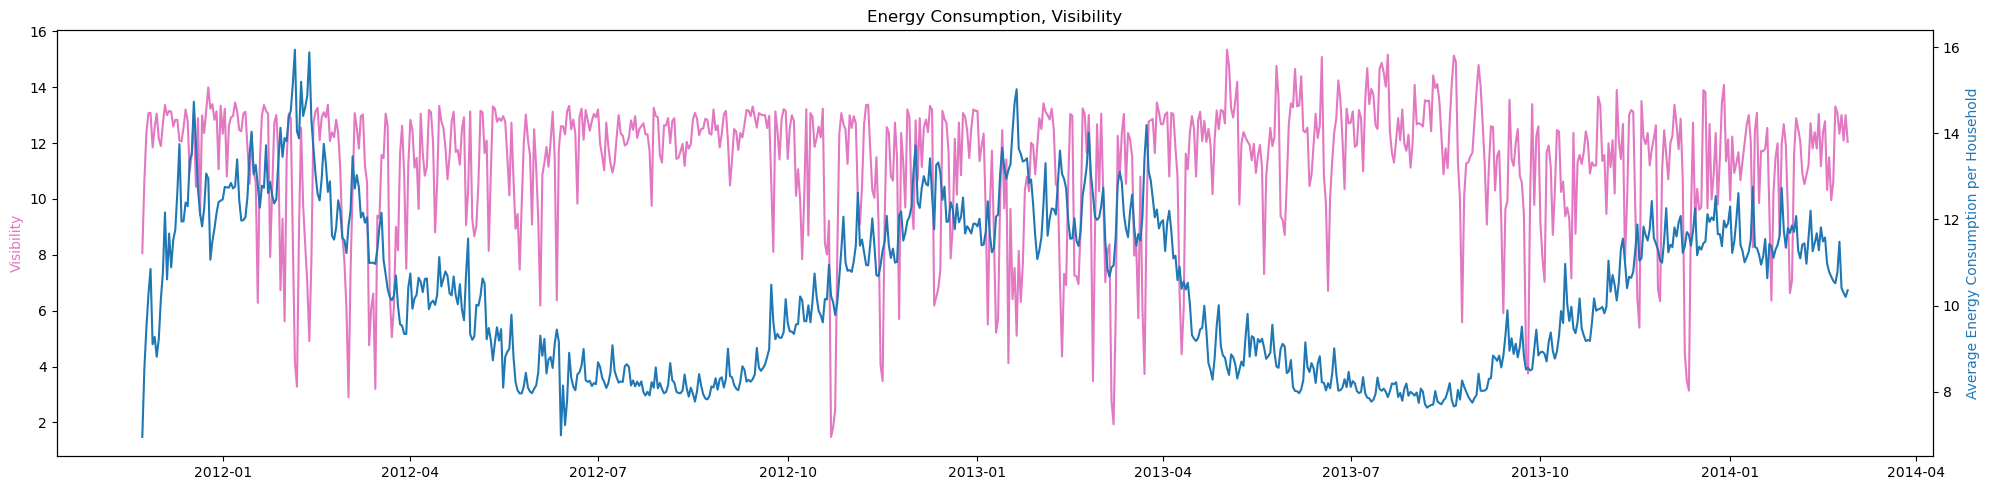

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(energy_weather_df.index, energy_weather_df['visibility'], color='tab:pink')
ax1.set_ylabel('Visibility', color='tab:pink')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energy Consumption per Household', color='tab:blue')
plt.title('Energy Consumption, Visibility')
fig.tight_layout()
plt.show()

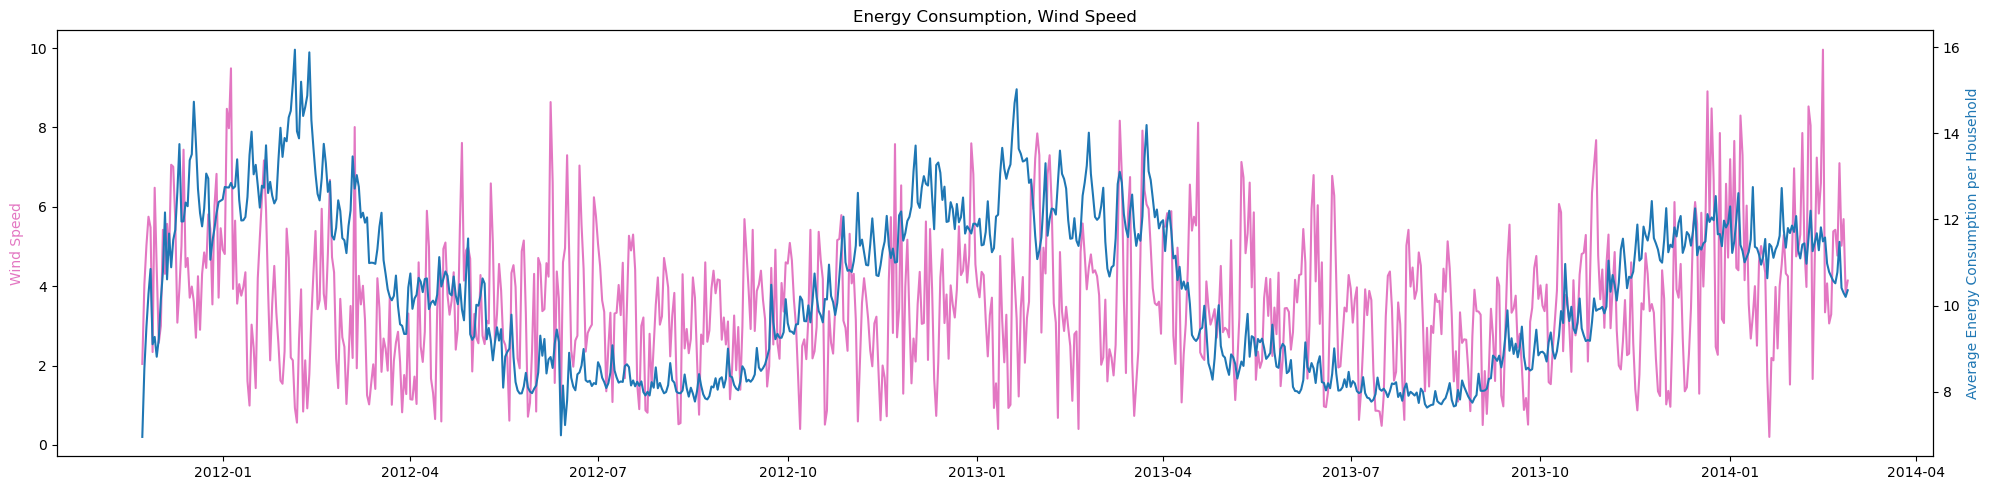

In [36]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(energy_weather_df.index, energy_weather_df['windSpeed'], color='tab:pink')
ax1.set_ylabel('Wind Speed', color='tab:pink')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energy Consumption per Household', color='tab:blue')
plt.title('Energy Consumption, Wind Speed')
fig.tight_layout()
plt.show()

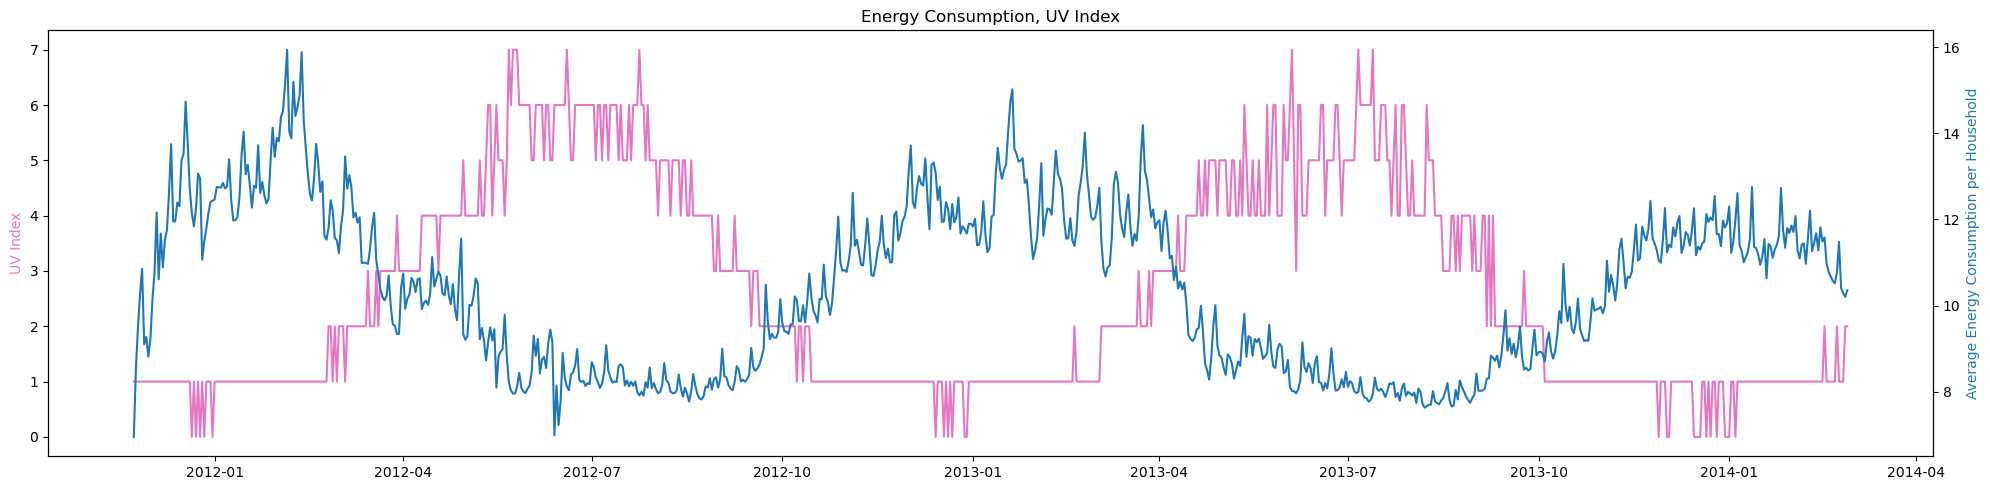

In [37]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(energy_weather_df.index, energy_weather_df['uvIndex'], color='tab:pink')
ax1.set_ylabel('UV Index', color='tab:pink')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energy Consumption per Household', color='tab:blue')
plt.title('Energy Consumption, UV Index')
fig.tight_layout()
plt.show()

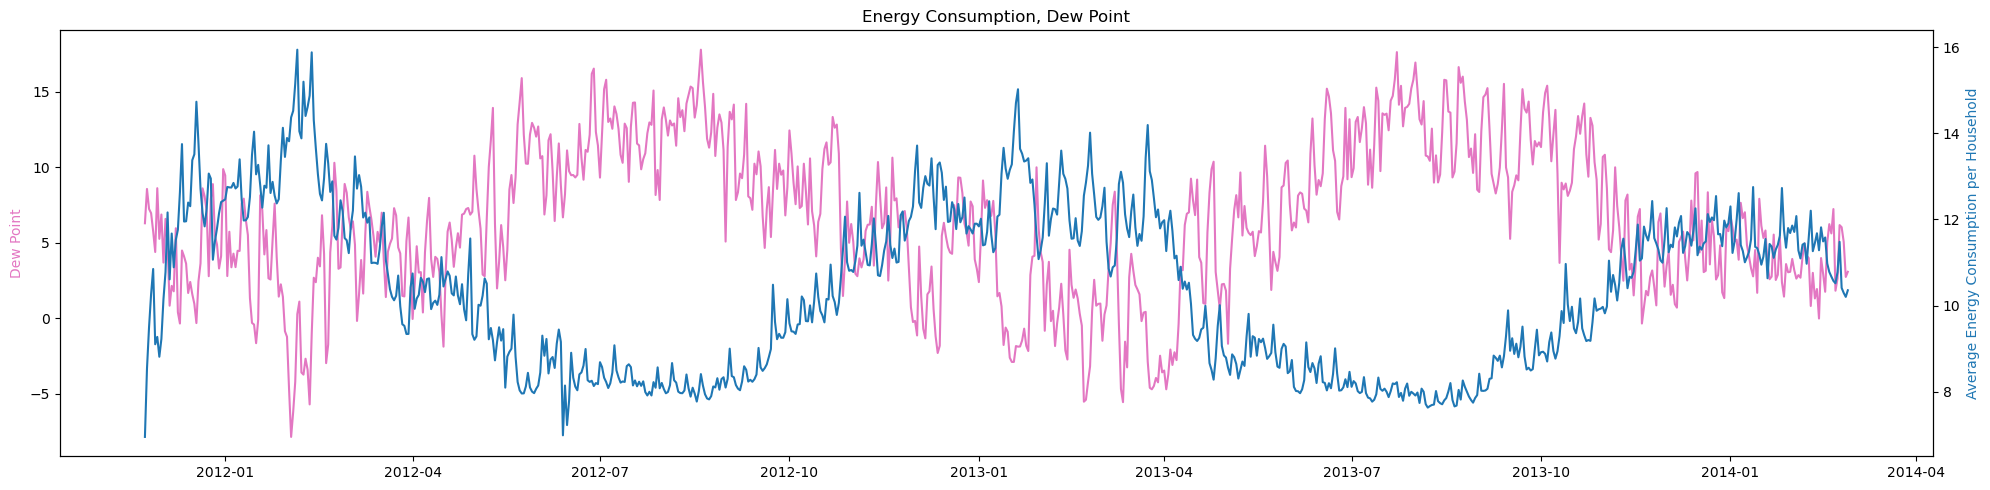

In [38]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(energy_weather_df.index, energy_weather_df['dewPoint'], color='tab:pink')
ax1.set_ylabel('Dew Point', color='tab:pink')
ax2 = ax1.twinx()
ax2.plot(energy_weather_df.index, energy_weather_df['average_energy'], color='tab:blue')
ax2.set_ylabel('Average Energy Consumption per Household', color='tab:blue')
plt.title('Energy Consumption, Dew Point')
fig.tight_layout()
plt.show()

It looks as though there's at least some correlation between energy consumption and the various weather attributes, and possible collinearity between weather attributes.

### Measuring stationarity of the time series

We can intuitively think about stationarity as the state where the statistical properties of the distribution from which the time series is sampled remain constant over time.

- Trend - does the mean change over time?
- Heteroscedasticity - does the variance change over time?
- Seasonality - are there periodic changes in the mean?
- Unit root - does the time series resemble a random walk, i.e. have a constant mean but non-constant variance?

In [39]:
# Define some columns of interest for examining stationarity
columns_of_interest = [
    'total_energy',
    'average_energy',
    'temperatureMax',
    'windBearing',
    'dewPoint',
    'cloudCover',
    'windSpeed',
    'pressure',
    'apparentTemperatureHigh',
    'visibility',
    'humidity',
    'apparentTemperatureLow',
    'apparentTemperatureMax',
    'uvIndex',
    'temperatureLow',
    'temperatureMin',
    'temperatureHigh',
    'apparentTemperatureMin'
]

### Augemented Dickey-Fuller Test (unit root)

The null hypothesis is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

In [40]:
# If p < 0.05, there is a 95% probability that the series does not have a unit root; 
# the series is stationary from a unit root perspective

# Perform augmented Dickey-Fuller test on columns of interest
def get_adfuller_p_values(df, column_names, threshold=0.05):
    p_values_df = pd.DataFrame(columns=['series_name', 'p_value', 'is_stationary'])
    for column in column_names:

        # Perform the ADF test on the column
        result = adfuller(df[column])
        
        # Extract the p-value from the result
        p_value = result[1]

        # Create a temporary DataFrame with the column name and p-value
        temp_df = pd.DataFrame({'series_name': [column], 'p_value': [p_value], 'is_stationary': p_value < threshold})
    
        # Concatenate the temporary DataFrame with the main DataFrame
        p_values_df = pd.concat([p_values_df, temp_df], ignore_index=True)

    return p_values_df.sort_values(by='is_stationary')

In [41]:
get_adfuller_p_values(energy_weather_df, columns_of_interest)

,series_name,p_value,is_stationary
0,total_energy,2.418241e-01,False
13,uvIndex,5.643747e-01,False
17,apparentTemperatureMin,1.035264e-01,False
1,average_energy,2.696540e-01,False
2,temperatureMax,5.990860e-02,False
3,windBearing,6.613414e-17,True
4,dewPoint,2.936118e-02,True
5,cloudCover,3.837400e-19,True
6,windSpeed,4.644622e-30,True
7,pressure,3.195993e-13,True


We can see that our energy series, as well as some of our temperature weather attributes, cannot be considered stationary from a unit root perspective. 

### Kendall's Tau (trend)

Kendall’s Tau is a measure of correlation but carried out on the ranks of the data. The correlation coefficient, Tau, returns a value between -1 and 1, where 0 shows no relationship and 1 or -1 is a perfect relationship.

If we chose one of the variables to be the time series and set the other as the ordinal representation of time, the resulting Kendall’s Tau would represent the trend in the time series. The higher the value of Kendall’s Tau, the stronger we expect the trend to be.

In [42]:
# If p < 0.05, we conclude that the trend in the series is 
# statistically significant at the 95% confidence level

# Perform augmented Dickey-Fuller test on columns of interest
def get_kendalltau_p_values(df, column_names, threshold=0.05):
    p_values_df = pd.DataFrame(columns=['series_name', 'p_value', 'significant_trend'])
    for column in column_names:

        # Perform the Kendall's Tau for the series by comparing the series
        # with an ordinal representation of time       
        result = stats.kendalltau(df[column], np.arange(len(df[column])))
        
        # Extract the p-value from the result
        p_value = result[1]

        # Create a temporary DataFrame with the column name and p-value
        temp_df = pd.DataFrame({'series_name': [column], 'p_value': [p_value], 'significant_trend': p_value < threshold})
    
        # Concatenate the temporary DataFrame with the main DataFrame
        p_values_df = pd.concat([p_values_df, temp_df], ignore_index=True)

    return p_values_df.sort_values(by='significant_trend', ascending=False)

In [43]:
get_kendalltau_p_values(energy_weather_df, columns_of_interest)

,series_name,p_value,significant_trend
0,total_energy,2.227928e-108,True
13,uvIndex,4.975241e-04,True
7,pressure,2.812479e-08,True
1,average_energy,2.067512e-04,True
10,humidity,8.439344e-01,False
16,temperatureHigh,4.858418e-01,False
15,temperatureMin,7.383524e-02,False
14,temperatureLow,6.972800e-02,False
12,apparentTemperatureMax,4.832475e-01,False
11,apparentTemperatureLow,1.123179e-01,False


We have a significant trend in our `average_energy` column.

### Autocorrelation (seasonality)

Darts' `check_seasonality` function works by inferring a unique seasonality period from the auto-correlation function of a series. It works as follows:

1. Calculates the ACF.

2. Finds all the relative maxima in the ACF.

3. Checks whether the provided seasonal_period is a relative maximum. If not, we conclude 
there is no seasonality associated with seasonality_period.

3. Assume that the ACF is normally distributed and compute the upper 
limit at the specified confidence level. 

5. Each each candidate for seasonality_period against this upper limit and 
the ones that are above this limit are deemed statistically significant.

6. Return the first admissible value.

In [56]:
# Use Darts to extract the first statistically significant seasonality period for each series
def get_seasonality_periods(df, column_names, threshold=0.05):
    periods_df = pd.DataFrame(columns=['series_name', 'has_seasonality', 'period'])
    for column in column_names:

        # convert the column into a Darts TimeSeries object      
        darts_time_series = TimeSeries.from_series(df[column])
        
        # Perform the seasonality check
        result = check_seasonality(darts_time_series, alpha=threshold)

        # Create a temporary DataFrame with the column name and p-value
        temp_df = pd.DataFrame({'series_name': [column], 'has_seasonality': result[0], 'period': result[1]})
    
        # Concatenate the temporary DataFrame with the main DataFrame
        periods_df = pd.concat([periods_df, temp_df], ignore_index=True)

    return periods_df.sort_values(by='period', ascending=False)

In [57]:
get_seasonality_periods(energy_weather_df, columns_of_interest)

,series_name,has_seasonality,period
7,pressure,True,9
3,windBearing,True,7
1,average_energy,True,7
9,visibility,True,6
15,temperatureMin,True,6
14,temperatureLow,True,6
11,apparentTemperatureLow,True,6
17,apparentTemperatureMin,True,6
6,windSpeed,True,6
4,dewPoint,True,6


For daily data, a period of 7 indicates a period of one week.